# Feature engineering with Buzzfeed planes

When you're working on flight data, you don't get a nice description of where and how the plane flies - you're stuck with a series of individual measurements. In this notebook we'll work on engineering some descriptive features about each plane's "normal" way of flying.

<p class="reading-options">
  <a class="btn" href="/buzzfeed-spy-planes/feature-engineering-buzzfeed-spy-planes">
    <i class="fa fa-sm fa-book"></i>
    Read online
  </a>
  <a class="btn" href="/buzzfeed-spy-planes/notebooks/Feature engineering - Buzzfeed spy planes.ipynb">
    <i class="fa fa-sm fa-download"></i>
    Download notebook
  </a>
  <a class="btn" href="https://colab.research.google.com/github/littlecolumns/ds4j-notebooks/blob/master/buzzfeed-spy-planes/notebooks/Feature engineering - Buzzfeed spy planes.ipynb" target="_new">
    <i class="fa fa-sm fa-laptop"></i>
    Interactive version
  </a>
</p>

### Prep work: Downloading necessary files
Before we get started, we need to download all of the data we'll be using.
* **flights_data4-1529539200-cleaned.csv:** raw flight data - a selection of raw data from from opensky


In [ ]:
# Make data directory if it doesn't exist
!mkdir -p data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/buzzfeed-spy-planes/data/flights_data4-1529539200-cleaned.csv.zip -P data
!unzip -n -d data data/flights_data4-1529539200-cleaned.csv.zip

You might need to install `pyproj` and `shapely` libraries for this one. You can uncomment the lines below and run them to (hopefully) get the installation done.

In [1]:
# !pip install pyproj
# !pip install shapely

# Imports

In [2]:
# Normal imports for data analysis
import pandas as pd 
import numpy as np

# Extra geographic bits, only used for for calculating fly zone area
from shapely.geometry import Polygon
from pyproj import Transformer                                                                                                                

%matplotlib inline

# Read in our dataset

First we'll read in the dataset. Each organization you can get data from - OpenSky, FlightRadar24, etc - comes with slightly different columns. This set is from OpenSky.

In [3]:
df = pd.read_csv('data/flights_data4-1529539200-cleaned.csv', dtype={'icao24': 'str'})
df.head()

,icao24,callsign,day,firstseen,lastseen,estdepartureairport,estarrivalairport,time,altitude,latitude,longitude,heading
0,a09909,NaN,1529539200,1.529574e+09,1529574562,KPWK,IN93,1529574561,609.6,41.702100,-86.469939,88.232170
1,a09909,NaN,1529539200,1.529574e+09,1529574562,KPWK,IN93,1529574559,609.6,41.702042,-86.472140,88.253716
2,a09909,NaN,1529539200,1.529574e+09,1529574562,KPWK,IN93,1529574490,914.4,41.700657,-86.553040,88.451843
3,a09909,NaN,1529539200,1.529574e+09,1529574562,KPWK,IN93,1529574466,1219.2,41.703683,-86.587595,111.037514
4,a09909,NaN,1529539200,1.529574e+09,1529574562,KPWK,IN93,1529574465,1219.2,41.703962,-86.588681,111.037514


When we sit down to do our machine learning, our question is going to be: **is this plane a surveillance plane or not?** Probably a bunch of rows, one per plane, each one having a prediction of `0` (not surveillance) or `1` (surveillance). It seems like a silly thing to call out, but... take a look at our data.

**Each row isn't a plane, it's a single reading from that plane in flight!** This is going to cause some trouble. We can't predict whether each reading is a spy plane or not, because each reading doesn't have enough information in it. Each row has a time, altitude, coordinates, a heading, and a few other columns, but saying "you're flying north at these coordinates" is definitely not good enough to say whether something is a surveillance plane or not.

We'll somehow need to summarize all of these readings into a single row, to illustrate how the plane flies in a way that we can tell apart surveillance and non-surveillance planes. This calls for **feature engineering!**

# Feature engineering

Most of the time when we're doing machine learning, we have a list of columns we can plug into our machine learning algorithm. Maybe we divide a column by a thousand, or turn it into a percent instead of a raw number, but nothing really too crazy. Our main goal is **feature selection**, which is picking which columns to use.

In this case, though, we need to actually design all of these features. We'll pick apart each plane's flight paths using the coordinates, and turn it into a single row.


## Picking features to engineer for surveillance plane detection

**What might make a spy plane unique?** Buzzfeed had some ideas:

* How fast thep plane goes
* Where the plane flies
* How large of an area the plane flies over
* How often the plane changes direction
* How high each flight usually is
* How long each flight is
* What type of plane it is

Your first instinct might be to calculate an average for each one of these. For example, how long is an average flight? and how fast does the plane usually go? Instead of sticking at this level, Peter went a bit further.

## Feature engineering example: Altitude quantiles

**Let's see Peter's alterantive, using altitude as an example.** For example, let's say we're interested in plane `a4f179`.

In [4]:
df[df.icao24 == 'a4f179'].head()

,icao24,callsign,day,firstseen,lastseen,estdepartureairport,estarrivalairport,time,altitude,latitude,longitude,heading
1096564,a4f179,MSQT714,1529539200,1.529614e+09,1529614495,2AZ7,2AZ3,1529614493,1219.2,33.748993,-112.408242,299.500732
1096565,a4f179,MSQT714,1529539200,1.529614e+09,1529614495,2AZ7,2AZ3,1529614491,1219.2,33.748489,-112.407177,300.398743
1096566,a4f179,MSQT714,1529539200,1.529614e+09,1529614495,2AZ7,2AZ3,1529614463,1219.2,33.742310,-112.395406,311.185913
1096567,a4f179,MSQT714,1529539200,1.529614e+09,1529614495,2AZ7,2AZ3,1529614461,1219.2,33.741574,-112.394371,311.128754
1096568,a4f179,MSQT714,1529539200,1.529614e+09,1529614495,2AZ7,2AZ3,1529614460,1219.2,33.741295,-112.393970,307.715973


How many readings do we have for this one? It's important to know what we're generally working with.

In [5]:
df[df.icao24 == 'a4f179'].shape

(3723, 12)

Wow, almost four thousand! That's a lot of info. Since we're focused on breaking it down to one row, though, we could ask "how high does this plane usually fly?"

In [6]:
df[df.icao24 == 'a4f179'].altitude.mean()

1001.4272360999194

That number might not mean much on its own, as we don't know if it's high or low. We'd need to compare it to other planes to see what that speed really looks like (...yeah, yeah, this isn't exactly true, but bear with me).

Let's get the mean altitude of *all* readings.

In [7]:
df.altitude.mean()

4684.43290572469

Okay, cool, so our plane seems to generally fly a lot lower than other planes. But I'm conflicted - we took 3800 altitude datapoints and turned it into one! It seems like like we're throwing out a lot of data that might prove useful in tracking down planes. **Instead of reducing a plane to *one* number, let's see if we have any alternatives.**

Think about all the questions you might ask about how planes fly. Do almost all planes fly at the same altitude? When they're flying, do they usually stay at one altitude? Or do they go up and down, in a way that measuring the mean won't capture?

We don't know anything about planes, so maybe we should ask what a "normal" flight looks like beyond just the mean. A histogram could help us there!

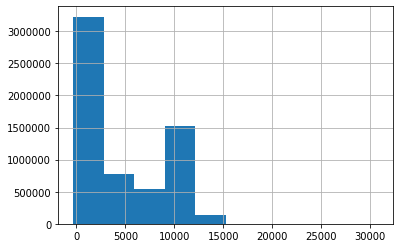

In [8]:
df.altitude.hist()

Wow, interesting! It seems like there's a lot of low-flying planes, and then a big peak at 10,000, but plenty between and above. It might be useful to capture that numerically. We could ask for quartiles, but let's go a little more complex: **what are the 20%, 40%, 60% and 80% boundaries for altitude?**

In [9]:
quantiles = df.altitude.quantile([0.2, 0.4, 0.6, 0.8])
quantiles

0.2      914.4
0.4     1828.8
0.6     4572.0
0.8    10058.4
Name: altitude, dtype: float64

Remember how we were "throwing out a lot of data" by reducing our altitude measurements to just an average? The way Peter got around this way to **count each measurement separately.**

His question became: **compared to an average plane, how often was our plane in each altitude group?** How often was between the the 0-20% altitude? or the 20-40% altitude? or the 40-60% latitude?

A very average plane will always be in the 40-60% range. A plane that's always flying high is in the 80-100% group. A low-flying plane would be in 0-20%. If you split your time between high and low, you'll have entries in both 0-20% _and_ 80-100%. **This is a great way to summarize your data without throwing it all out.**

Let's perform that analysis with our `a4f179` plane, seeing how much time it spends in each bucket.

In [10]:
# Create buckets based on the quantiles of all planes,
# reusing our variable from above
bin_quantiles = [-np.inf, *quantiles, np.inf]

# altitude1: -infinity to 914.4
# altitude2: 914.4     to 1,828.8
# altitude3: 1,828.8   to 4,572.0
# altitude4: 4,572.0   to 10,058.4
# altitude5: 10,058.4  to infinity
bin_labels = ['altitude1','altitude2','altitude3','altitude4','altitude5']

# Get the altitudes for just this plane
altitudes = df[df.icao24 == 'a4f179'].altitude

# Count how many altitude reading are in each bucket
# normalize=True to give us percentages
# bins=bin_labels to name them
# sort=False so we can see them in order of 1-5
# * 100 to convert to percentages because it's easier to read
pd.cut(altitudes, 
       bins=bin_quantiles,
       labels=bin_labels).value_counts(sort=False, normalize=True) * 100

altitude1    18.614021
altitude2    81.385979
altitude3     0.000000
altitude4     0.000000
altitude5     0.000000
Name: altitude, dtype: float64

So our plane spends about **18% of its time flying low, and 80% of its time flying medium-low.** Let's compare that with another plane, `a97db4`.

In [11]:
altitudes = df[df.icao24 == 'a97db4'].altitude

pd.cut(altitudes, 
       bins=bin_quantiles,
       labels=bin_labels).value_counts(sort=False, normalize=True) * 100

altitude1     1.923788
altitude2     8.694044
altitude3     5.438402
altitude4     8.213097
altitude5    75.730670
Name: altitude, dtype: float64

This plane is a completely different beast! Instead of spending most of its time low, it works its way up to the highest altitudes and spends around 76% of its time there. It's a **very** different pattern than our first plane, and gives a good summary that we might not have gotten if we just took the mean.

## Calculating other feature quantiles

Now that we have an idea of what we're going to be doing, let's get started! And to make things a bit easier, Buzzfeed didn't actually process these quantiles for all of the planes in its dataset:

> Then we took a random sample of **500 aircraft** and calculated the following for each one:

So we can start by **pulling a sample of planes**. Note that we can't just ask for 500 random rows - we have to ask for 500 unique *plane identifiers* and then use those to select our rows.

In [12]:
unique_icao24 = df.icao24.unique()

sample_icao24 = np.random.choice(unique_icao24, 500)
sample_icao24[:5]

array(['a06a7e', 'a9df59', 'a9e391', 'ae0232', 'a5ddea'], dtype=object)

Now we can select our readings for the sample planes.

In [13]:
sample_df = df[df.icao24.isin(sample_icao24)]
sample_df.shape

(239188, 12)

# Calculate quantiles

> Then we took a random sample of 500 aircraft and calculated the following for each one:
> 
> * **duration** of each flight segment recorded by Flightradar24, in minutes.
> * **boxes** Area of a rectangular bounding box drawn around each flight segment, in square kilometers.

## Altitude quantiles

Since we basically did altitude already, though, we'll throw that in there.

In [14]:
# Get a list of altitudes
altitudes = df.set_index('icao24').altitude

In [15]:
# Calculate quantiles from the sample and calculate each plane's behavior
quantiles = altitudes.loc[sample_icao24].quantile([0.2, 0.4, 0.6, 0.8])

bin_quantiles = [-np.inf, *quantiles, np.inf]
bin_labels = ['altitude1','altitude2','altitude3','altitude4','altitude5']

binned = pd.cut(altitudes,
                bins=bin_quantiles,
                labels=bin_labels)

altitude_features = binned.groupby(['icao24']).value_counts(normalize=True).unstack(fill_value=0) * 100
altitude_features.head()

altitude,altitude1,altitude2,altitude3,altitude4,altitude5
icao24,,,,,
000001,70.951157,28.149100,0.899743,0.000000,0.000000
009f55,0.000000,0.000000,0.000000,100.000000,0.000000
00b0ec,17.757009,26.168224,32.710280,14.953271,8.411215
00b1fa,37.500000,24.038462,9.134615,20.192308,9.134615
00b208,13.580247,32.098765,17.283951,33.333333,3.703704


## Flight duration quantiles

Calculate flight durations for all of our planes. We're grouping by the plane ID and the `firstseen` column, which indicates a new flight.

In [16]:
flight_times = df.groupby(['icao24', 'firstseen']).lastseen.last().reset_index(level=1)
flight_times.head()

,firstseen,lastseen
icao24,,
000001,1.529539e+09,1529539737
000001,1.529541e+09,1529571558
000001,1.529595e+09,1529610553
009f55,1.529586e+09,1529587568
00b0ec,1.529523e+09,1529576455


We can then subtract the two to get the duration for each flight.

In [17]:
durations = flight_times.lastseen - flight_times.firstseen
durations.head()

icao24
000001      894.0
000001    30940.0
000001    15530.0
009f55     1695.0
00b0ec    53862.0
dtype: float64

In [18]:
# Calculate quantiles from the sample and calculate each plane's behavior
quantiles = durations.loc[sample_icao24].quantile([0.2, 0.4, 0.6, 0.8])

bin_quantiles = [-np.inf, *quantiles, np.inf]
bin_labels = ['duration1','duration2','duration3','duration4','duration5']

binned = pd.cut(durations,
                bins=bin_quantiles,
                labels=bin_labels)

duration_features = binned.groupby(['icao24']).value_counts(normalize=True).unstack(fill_value=0) * 100
duration_features.head()

,duration1,duration2,duration3,duration4,duration5
icao24,,,,,
000001,33.333333,0.0,0.0,0.0,66.666667
009f55,0.000000,100.0,0.0,0.0,0.000000
00b0ec,0.000000,0.0,0.0,0.0,100.000000
00b1fa,0.000000,0.0,0.0,0.0,100.000000
00b208,0.000000,0.0,0.0,0.0,100.000000


# Speed quantiles

> TODO speed!!!

In [19]:
df.head(2)

,icao24,callsign,day,firstseen,lastseen,estdepartureairport,estarrivalairport,time,altitude,latitude,longitude,heading
0,a09909,NaN,1529539200,1.529574e+09,1529574562,KPWK,IN93,1529574561,609.6,41.702100,-86.469939,88.232170
1,a09909,NaN,1529539200,1.529574e+09,1529574562,KPWK,IN93,1529574559,609.6,41.702042,-86.472140,88.253716


# Bounding box area quintiles

We'll calculate for everyone, then get quintiles from the sample

In [20]:
# Calculate min/max for each flight's lat/lon
coords = df.groupby(['icao24', 'firstseen']).agg({
    'latitude': ['min', 'max'],
    'longitude': ['min', 'max']
}).reset_index(level=1, drop=True)
coords.head()

latitude              longitude            
              min        max         min         max
icao24                                              
000001  34.875229  34.885409  -86.809593  -86.707801
000001  34.777222  34.881821  -86.809312  -86.692085
000001  33.032364  33.679613 -111.994124 -111.361322
009f55  34.681184  37.396591  -80.488294  -78.992672
00b0ec  37.990173  40.612033  -73.915267  -68.287626

In [21]:
# Calculate the bounding box in km for those
# Yeah, sorry this is complicated

transformer = Transformer.from_crs('epsg:4326', 'epsg:3857')

def get_area(row):
    coords_y = [
        row['longitude']['min'],
        row['longitude']['max'],
        row['longitude']['max'],
        row['longitude']['min'],
    ]
    coords_x = [
        row['latitude']['max'],
        row['latitude']['max'],
        row['latitude']['min'],
        row['latitude']['min'],
    ]

    # This is so much faster than going the shapely route
    # but also slower than it used to be?
    lon, lat = transformer.transform(coords_x, coords_y)
    square_m = Polygon(zip(lon, lat)).area
    square_km = square_m / (1000 * 1000)
    return square_km

areas = coords.apply(get_area, axis=1)
areas.head()

icao24
000001        15.653545
000001       185.110905
000001      6076.579771
009f55     62250.036094
00b0ec    236331.915381
dtype: float64

In [22]:
# Calculate quantiles from the sample and calculate each plane's behavior
quantiles = areas.loc[sample_icao24].quantile([0.2, 0.4, 0.6, 0.8])

bin_quantiles = [-np.inf, *quantiles, np.inf]
bin_labels = ['area1','area2','area3','area4','area5']

binned = pd.cut(areas,
                bins=bin_quantiles,
                labels=bin_labels)

area_features = binned.groupby(['icao24']).value_counts(normalize=True).unstack(fill_value=0) * 100
area_features.head()

,area1,area2,area3,area4,area5
icao24,,,,,
000001,100.0,0.0,0.0,0.0,0.0
009f55,0.0,100.0,0.0,0.0,0.0
00b0ec,0.0,0.0,100.0,0.0,0.0
00b1fa,0.0,0.0,100.0,0.0,0.0
00b208,0.0,0.0,100.0,0.0,0.0


## Compute the steering

Each measurement has a heading, the direction the plane is going. By calculating the difference between one heading and the next, we can calculate in which direction the plane was steered.

In [23]:
df['steering'] = df.groupby(['icao24', 'firstseen']).heading.diff()
df.head()

,icao24,callsign,day,firstseen,lastseen,estdepartureairport,estarrivalairport,time,altitude,latitude,longitude,heading,steering
0,a09909,NaN,1529539200,1.529574e+09,1529574562,KPWK,IN93,1529574561,609.6,41.702100,-86.469939,88.232170,NaN
1,a09909,NaN,1529539200,1.529574e+09,1529574562,KPWK,IN93,1529574559,609.6,41.702042,-86.472140,88.253716,0.021545
2,a09909,NaN,1529539200,1.529574e+09,1529574562,KPWK,IN93,1529574490,914.4,41.700657,-86.553040,88.451843,0.198128
3,a09909,NaN,1529539200,1.529574e+09,1529574562,KPWK,IN93,1529574466,1219.2,41.703683,-86.587595,111.037514,22.585670
4,a09909,NaN,1529539200,1.529574e+09,1529574562,KPWK,IN93,1529574465,1219.2,41.703962,-86.588681,111.037514,0.000000


In [24]:
steerings = df.set_index('icao24').steering
steerings.head()

icao24
a09909          NaN
a09909     0.021545
a09909     0.198128
a09909    22.585670
a09909     0.000000
Name: steering, dtype: float64

Since we aren't quite sure how much steering goes into flying a plane, we can take a look at a histogram to try to understand it.

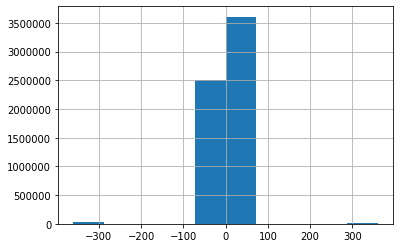

In [25]:
steerings.hist()

Notice those +/- 300-something turns? It's a side effect of our calculation - think about what a 359 degree turn to the right is (Hint: it's just ONE DEGREE to the left). Let's get rid of them.

In [26]:
# Just in case it crossed the 360 barrier, we can only turn 180* L or R
steerings = steerings.apply(lambda direction: direction if direction <= 180 else direction - 360)
steerings = steerings.apply(lambda direction: direction if direction >= -180 else direction + 360)

steerings.head()

icao24
a09909          NaN
a09909     0.021545
a09909     0.198128
a09909    22.585670
a09909     0.000000
Name: steering, dtype: float64

Does the distribution still have those 300s in there?

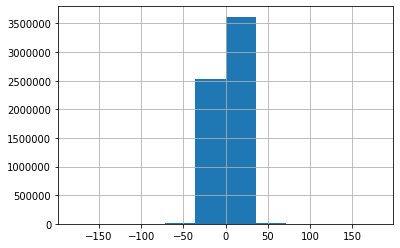

In [27]:
steerings.hist()

That looks more reasonable - now we can run some calculations. **Peter didn't use quantiles for this one**, he used his own boundaries.

In [28]:
# Calculate quantiles from the sample and calculate each plane's behavior
#quantiles = areas.loc[sample_icao24].quantile([0.2, 0.4, 0.6, 0.8])
quantiles = [-25, -10, -1, 0, 1, 22, 45]

bin_quantiles = [-np.inf, *quantiles, np.inf]
bin_labels = ['steer1','steer2','steer3','steer4','steer5', 'steer6', 'steer7', 'steer8']

binned = pd.cut(steerings,
                bins=bin_quantiles,
                labels=bin_labels)

steer_features = binned.groupby(['icao24']).value_counts(normalize=True).unstack(fill_value=0) * 100
steer_features.head()

steering,steer1,steer2,steer3,steer4,steer5,steer6,steer7,steer8
icao24,,,,,,,,
000001,1.609788,2.318094,56.213780,6.696716,3.090792,27.817128,1.094656,1.159047
009f55,0.000000,0.000000,29.411765,23.529412,41.176471,5.882353,0.000000,0.000000
00b0ec,0.000000,0.943396,48.113208,8.490566,16.037736,26.415094,0.000000,0.000000
00b1fa,0.000000,0.000000,42.028986,12.077295,10.628019,35.265700,0.000000,0.000000
00b208,0.000000,0.000000,63.975155,16.770186,5.590062,13.043478,0.621118,0.000000


## Observations: How many times did each plane show up in our dataset?

In [29]:
count_features = df.groupby('icao24').size().to_frame(name='observations')
count_features.head(2)

,observations
icao24,
000001,1556
009f55,18


# Combine everything into a features set

Now that we have multiple dataframes of features, we can concatenate them all together based on the `iaco24` index and have a nice big set of features.

In [30]:
features = pd.concat([
    altitude_features,
    duration_features,
    area_features,
    steer_features,
    count_features
], axis=1, sort=False)
features.head(2)

,altitude1,altitude2,altitude3,altitude4,altitude5,duration1,duration2,duration3,duration4,duration5,...,area5,steer1,steer2,steer3,steer4,steer5,steer6,steer7,steer8,observations
000001,70.951157,28.1491,0.899743,0.0,0.0,33.333333,0.0,0.0,0.0,66.666667,...,0.0,1.609788,2.318094,56.213780,6.696716,3.090792,27.817128,1.094656,1.159047,1556
009f55,0.000000,0.0000,0.000000,100.0,0.0,0.000000,100.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,29.411765,23.529412,41.176471,5.882353,0.000000,0.000000,18


We'll also turn the `icao24` back into a column, and **capitalize it** to match the other popular datasets on the topic.

In [31]:
features = features.reset_index().rename(columns={ 'index': 'icao24'})
features.icao24 = features.icao24.str.upper()
features.head()

,icao24,altitude1,altitude2,altitude3,altitude4,altitude5,duration1,duration2,duration3,duration4,...,area5,steer1,steer2,steer3,steer4,steer5,steer6,steer7,steer8,observations
0,000001,70.951157,28.149100,0.899743,0.000000,0.000000,33.333333,0.0,0.0,0.0,...,0.0,1.609788,2.318094,56.213780,6.696716,3.090792,27.817128,1.094656,1.159047,1556
1,009F55,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,100.0,0.0,0.0,...,0.0,0.000000,0.000000,29.411765,23.529412,41.176471,5.882353,0.000000,0.000000,18
2,00B0EC,17.757009,26.168224,32.710280,14.953271,8.411215,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.943396,48.113208,8.490566,16.037736,26.415094,0.000000,0.000000,107
3,00B1FA,37.500000,24.038462,9.134615,20.192308,9.134615,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.000000,42.028986,12.077295,10.628019,35.265700,0.000000,0.000000,208
4,00B208,13.580247,32.098765,17.283951,33.333333,3.703704,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.000000,63.975155,16.770186,5.590062,13.043478,0.621118,0.000000,162


# Filtering for meaning and saving

Peter only kept planes that had over 500 measurements.

We have far fewer planes than he did (and a much smaller dataset), but for propriety's sake we'll do the same.

In [32]:
print("Before filtering", features.shape)
subset = features[features.observations > 500]
print("After filtering", subset.shape)

Before filtering (13840, 25)
After filtering (3965, 25)


In [33]:
# Save the filtered version
subset.to_csv("data/opensky-features.csv", index=False)

In [ ]:
# Save a copy of the full set just for experimentation
features.to_csv("data/opensky-features-full.csv", index=False)

# Review

We started off with a list of coordinates and other information for our planes, but needed to turn that into a **description of how the plane behaves in the air.** Adjusting your data to create new descriptive elements is called **feature engineering**, and is an important part of machine learning.

While we could have just used simple features like the average altitude and speed of our planes, we felt like that was throwing out a lot of our data. Instead, we divided the "average" behavior of a plane into 5 quantiles - 0-20%, 20-40%, 40-60%, 60-80%, and 80-100% - and saw how much time each plane spent in each quantile. For example, a slow, low-flying plane might spend most of its time in the 0-20% quantile for altitude and speed.

Although it was complicated, this method allowed us to create a more complete set of features describing how each plane flies. The hope is that these detailed features will allow us to better identify planes that are flown similarly to one another.

## Discussion topics

* Do you think these features do a better job of describing a plane than just the median or mean? Is that answer the same for all of the measurements we took?
* Which feature do you predict works best to describe surveillance planes?
* Why do we not use quantiles for steering? It might be interesting to check what the quantiles would have been.
* Can you think of other features that might be used to describe surveillance planes?
* Some organizations that publish this sort of data have agreements to not include military or government planes. Is that a reasonable request?
* What might be some uses of this data?
* How is this data collected? What are the requirements to be able to obtain it on your own?